In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [19]:
path = "../lightning_logs/version_7/"
predictions = torch.load(path + "test_predictions.pt")
data = torch.load("../data/processed/test_data.pt")
data_frame = torch.column_stack([data[:len(predictions)], predictions])

In [21]:
data_frame.shape

torch.Size([50000, 5])

In [20]:
# x_idx, y_idx, 2020, 2021
data_frame[(data_frame[:,2] == 0) & (data_frame[:,3] == 1)].shape

torch.Size([495, 5])

In [22]:
year_last_input = 2020
last_input = torch.load(f"../data/processed/biomass/30m/biomass_{year_last_input}.pt")
ground_truth = torch.load(f"../data/processed/biomass/30m/biomass_{year_last_input + 1}.pt")
prediction = last_input.clone()
probabilities = last_input.clone().to(float)

In [23]:
import matplotlib as mpl
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap.set_over('lightgrey')

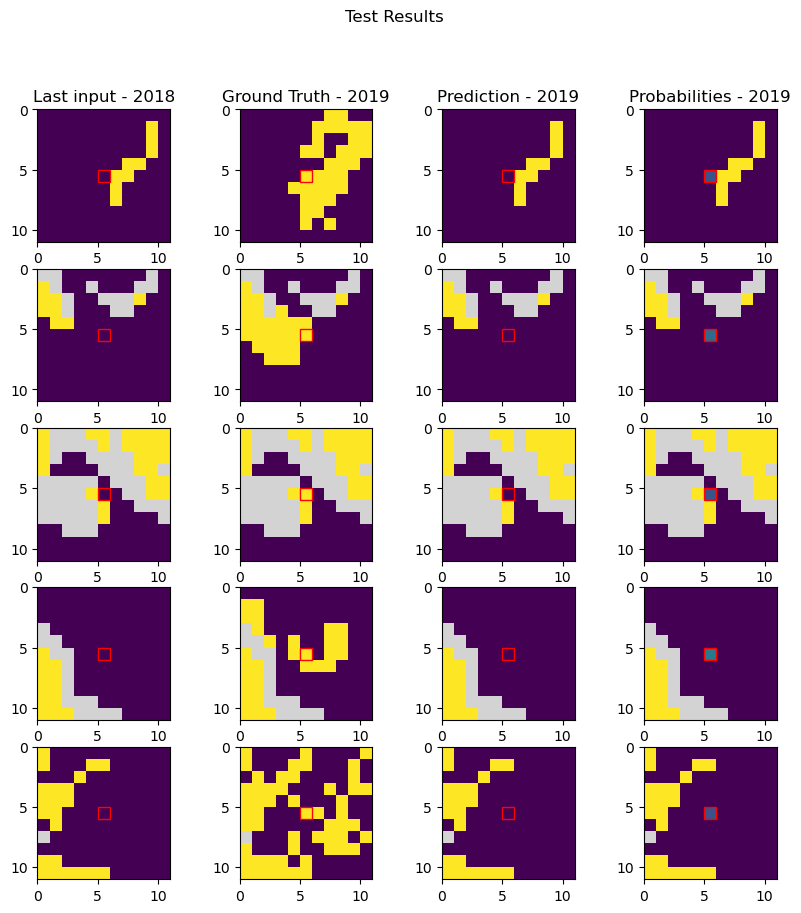

In [24]:
nr_points = 5
r = 5

# x_idx, y_idx, 2020, 2021, prediction
interesting_points = data_frame[(data_frame[:,2] == 0) & (data_frame[:,3] == 1)]
indices = torch.randperm(interesting_points.shape[0])
interesting_points = interesting_points[indices[:nr_points], :2]
interesting_points = interesting_points.numpy().astype(int)

fig, axs = plt.subplots(nr_points, 4, figsize=(10,10*int(nr_points/3)))
fig.suptitle("Test Results")

for idx, xy in enumerate(interesting_points):
    x = xy[0]; y = xy[1]
    for y_i in np.arange(y-r,y+r+1):
        for x_i in np.arange(x-r,x+r+1):
            model_predictions = data_frame[(data_frame[:,0] == x_i) & (data_frame[:,1] == y_i)]
            if len(model_predictions) == 1:
                prob = model_predictions[0,-1].item()
                probabilities[y_i,x_i] = prob
                prediction[y_i,x_i] = prob > 0.5

    if idx == 0:
        axs[idx,0].set_title("Last input - 2018")
        axs[idx,1].set_title("Ground Truth - 2019")
        axs[idx,2].set_title("Prediction - 2019")
        axs[idx,3].set_title("Probabilities - 2019")

    axs[idx,0].pcolormesh(last_input[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,0].add_patch(mpl.patches.Rectangle((r, r), 1, 1, fill=False, edgecolor='red'))
    axs[idx,0].invert_yaxis()
    axs[idx,0].set_aspect('equal', adjustable='box')

    axs[idx,1].pcolormesh(ground_truth[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,1].add_patch(mpl.patches.Rectangle((r, r), 1, 1, fill=False, edgecolor='red'))
    axs[idx,1].invert_yaxis()
    axs[idx,1].set_aspect('equal', adjustable='box')

    # axs[idx,2].pcolormesh(prediction[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,2].pcolormesh(prediction[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,2].add_patch(mpl.patches.Rectangle((r, r), 1, 1, fill=False, edgecolor='red'))
    axs[idx,2].invert_yaxis()
    axs[idx,2].set_aspect('equal', adjustable='box')

    axs[idx,3].pcolormesh(probabilities[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,3].add_patch(mpl.patches.Rectangle((r, r), 1, 1, fill=False, edgecolor='red'))
    axs[idx,3].invert_yaxis()
    axs[idx,3].set_aspect('equal', adjustable='box')

plt.show()